### Imports

In [1]:
# pytorch library
import torch

import torch.nn as nn
# optim is where we get the stochastic gradient descent optimiser from
import torch.optim as optim
# transforms perform a set of operations to an individual item (image) so that it is usable by the model
import torchvision.transforms as transforms
# Tools for creating datasets from folders
from torchvision import datasets
# default_loader enables basic loading of images to be used in the CustomDataset class
from torchvision.datasets.folder import default_loader
# DataLoader creates batches of data in a format the model can use
# Dataset is a general class that allows the retrieval of individual pieces of data via the DataLoader
# All classes that inherit from Dataset must implement the __getitem__ and __len__ 
from torch.utils.data import DataLoader, Dataset
import pandas as pd
# Metrics
from sklearn.metrics import accuracy_score, f1_score
# Plotting images
import matplotlib.pyplot as plt
import random


### Setup transform and define CustomDataset class for iterable datasets

In [2]:
transform=transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Use the train.csv and val.csv csv files to create two datasets
class CustomDataset(Dataset):
    # csv_file is a file path, root_dir is the root of the dataset, transform is an optional instantiation of transforms.Compose
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    # How many items are in the dataset
    def __len__(self):
        return len(self.data)
    
    # Get a specific item from the dataset by index
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx,0] # column 0 contains file paths
        img_path = f"{self.root_dir}/{img_name}"
        # A basic image loader that retruns a Python Imaging Library (PIL) object
        image = default_loader(img_path)
        label = self.data.iloc[idx,1] # column 1 contains image class

        # If there is a transform function, transform the image
        if self.transform:
            image = self.transform(image)

        return image, label

### Setup data

In [3]:
data_path = "../../datasets/bean-leaf-lesions/"

# CSV file paths
train_csv = data_path + 'train.csv'
val_csv = data_path + 'val.csv'

# Create custom datasets
train_dataset = CustomDataset(csv_file=train_csv, root_dir=data_path, transform=transform)
val_dataset = CustomDataset(csv_file=val_csv, root_dir=data_path, transform=transform)

# Create Dataloaders
batch_size=32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) 

In [4]:
# print how many batches are in the train and val dataloaders
print(f"Train batches: {len(train_dataloader)}")
print(f"Val batches: {len(val_dataloader)}")


Train batches: 33
Val batches: 5


### Create NN

In [5]:
# nn.Module is the base class for all NN modules in pytorch
class CNN(nn.Module):
    def __init__(self):
        # CNN class inherits from nn.Module
        # Inheriting allows the use of functions from the parent class
        super(CNN, self).__init__()
        # Input = RGB, Output = number of filters/kernels in the layer, 
        # kernel_size = height&width of convolutional window, padding = number of 0 pixels added to edge of image
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 16, kernel_size= 3, padding=1)
        # kernel_size = size of the max pooling window
        # step_size determines how much the kernel moves by after each pooling operation
        # With both of these being 2, the spatial dimension is halved
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # The number of outputs increases with the depth of the model because the complexity of the
        # learned representations requires more neurons
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # 32 is the previous layers output size, and 8 is the size of the image after the pooling layer
        # so 32 * 8 * 8 is the number of dimensions in the flattened tensor
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 3) # 3 possible classes in the dataset

    def forward(self, x):
        # Apply conv1 to the input, apply relu activation, apply max pooling
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        # x.view is a pytorch fn used to reshape tensors
        # This flattens the tensor into a 1D vector of 32*8*8 elements
        # The -1 is a placeholder to allow pytorch to automatically compute the size of that dimension
        # The total number of elements in the tensor is used (e.g. tensor contains 100 elems, x.view(5, -1) would resolve -1 to 20)
        x = x.view(-1, 32 * 32 * 32)
        # Puth the flattened tensor through a fully connected layer
        x = torch.relu(self.fc1(x))
        # Resolve to one of the 3 possible classes
        x = self.fc2(x)
        return x

model = CNN()

### Define loss function and optimiser

In [6]:
criterion = nn.CrossEntropyLoss() # Computes softmax as well as loss

# Momentum at 0.9 means that the gradient will be 90% influenced by previous gradients and 10% by the current
# Allows for faster convergence by moving more in steeper situations and less in shallow
optimiser = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Train

In [7]:
num_epochs=5

for epoch in range(num_epochs):
    running_loss=0.0
    total_predictions = []
    true_labels = []
    # Generates tuples containing index 'i' and elements 'data'
    # the 0 argument sets the index to begin at 0
    # the index refers to which batch of data we are currently looking at
    # the data refers to the collection of data points in that batch, with inputs and labels
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data

        # clears any previously generated gradients
        # For each data point, we n
        optimiser.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # computes gradients of the loss wrt model params with back-prop
        loss.backward()
        # Updates model parameters using gradients from loss.backward(), which stored the gradients within the model params
        # Since the model params are stored in the optimiser anyway, we do no need to explicitly handle this arg
        optimiser.step()

        # Record predictions and labels for computing metrics
        # outputs, 1 means that we record the maximum value along the 1st dimension of the outputs tensor
        # the _ is because it returns the value of the item as well as the index, and we do not need the value 
        # (we only need the predicted class)
        _, predicted = torch.max(outputs, 1)
        # we convert predicted to a list for consistency reasons. 
        # It is not strictly necessary in this case but is good practice
        total_predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

        running_loss += loss.item()
    
    # calculate accuracy and F1 score after each epoch
    train_accuracy = accuracy_score(true_labels, total_predictions)
    # type of average can be chosen as appropriate
    # With macro, each class contributes equally to the final metric regardless of class imbalance
    # F1 score is computed for each class independently and then the average is taken
    # This choice might not be appropriate in imbalanced datasets
    train_f1_score = f1_score(true_labels, total_predictions, average='macro')

    # Print the metrics after each epoch
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_dataloader)}, Training Accuracy: {train_accuracy}, Training F1 Score: {train_f1_score}')

Epoch 1, Loss: 1.092775745825334, Training Accuracy: 0.38878143133462284, Training F1 Score: 0.3058078546162124
Epoch 2, Loss: 1.063611388206482, Training Accuracy: 0.4864603481624758, Training F1 Score: 0.4479127851697555
Epoch 3, Loss: 1.0083803101019426, Training Accuracy: 0.5560928433268859, Training F1 Score: 0.5152319751047262
Epoch 4, Loss: 0.9208890615087567, Training Accuracy: 0.6054158607350096, Training F1 Score: 0.5866646493639666
Epoch 5, Loss: 0.8308781511855848, Training Accuracy: 0.660541586073501, Training F1 Score: 0.6568897682305622


### Evaluation

In [8]:
def evaluate_model(model, dataloader):
    # Model.eval() does a couple of things
    # By putting the model into evaluation mode, we remove things like batch normalisation 
    # and dropout. 
    # batch norm is only required to normalize the inputs for a specific batch by calculating
    # the mean and variance
    # dropout layers randomly deactivate neurons during training to prevent overftting
    # Neither batch norm or dropout were used in this model, but model.eval() is good practice
    model.eval()
    correct_images = []
    incorrect_images = []
    correct_labels = []
    incorrect_labels = []

    # Using torch.no_grad() stops pytorch tracking the gradients when performing operations
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for i in range(len(labels)):
                if predicted[i] == labels[i]:
                    correct_images.append(images[i])
                    correct_labels.append(labels[i])
                else:
                    incorrect_images.append(images[i])
                    incorrect_labels.append(labels[i]) # we store incorrect images with their correct label
    return correct_images, correct_labels, incorrect_images, incorrect_labels


In [9]:
correct_images, correct_labels, incorrect_images, incorrect_labels = evaluate_model(model, val_dataloader)

In [10]:
def show_images(images, labels, title):
    num_images = len(images)
    # Create grid of subplots to display images
    # 1 represents the number of rows in the grid
    # num_images is the number of columns in the grid
    # figsize(15, 5) sets the size of the figure to 15 inches wide and 5 inches tall
    # fig is the overall figure that contains the subplots
    # axes is a 2D array or list (list in this case) of axes objects representing each subplot in the grid
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    fig.suptitle(title)

    for i in range(num_images):
        # the 1,2,0 rearranges the dimensions of the tensor
        # e.g. the dimensions [C, H, W] become [H, W, C]
        # This changes the configuration from pytorch's default, to something readable by Matplotlibs imshow()
        axes[i].imshow(images[i].permute(1,2,0)) # If using pytorch tensor
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off') # removes axis ticks and labels

### Display some images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


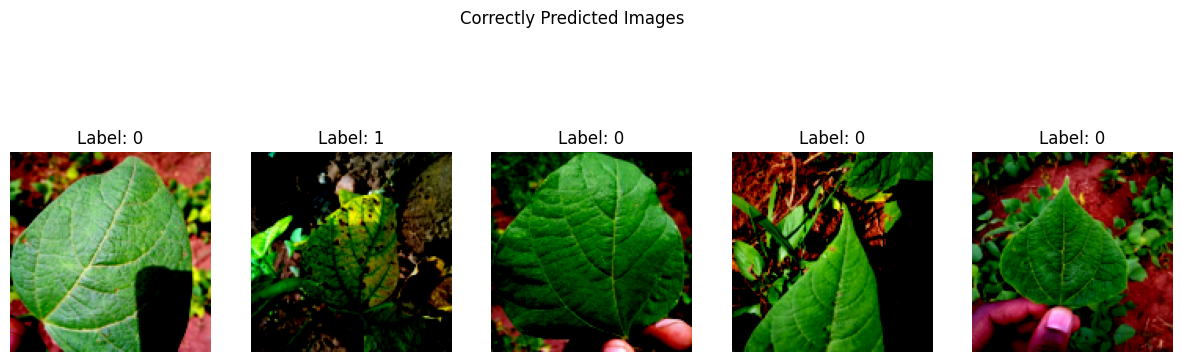

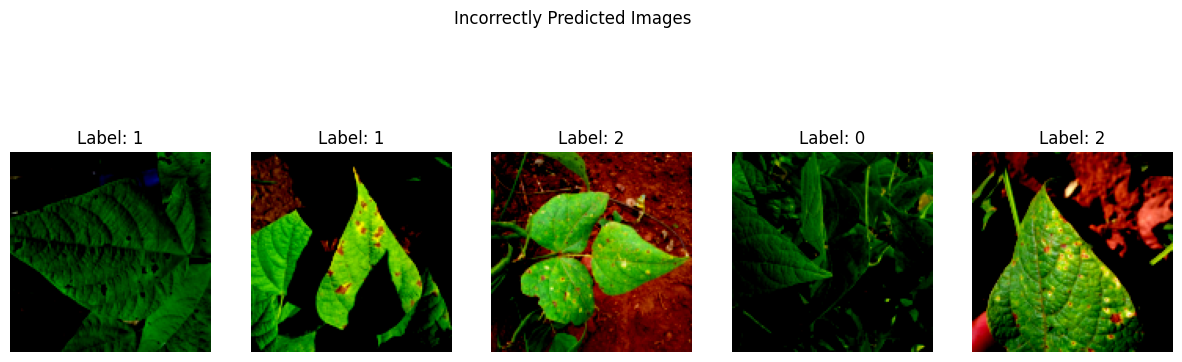

In [11]:

def select_random(images, labels, n):
    l = len(images)
    images_out = []
    labels_out = []
    for _ in range(n):
        index = random.randint(0,l)
        images_out.append(images[index])
        labels_out.append(labels[index])
    return images_out, labels_out


# Correct images
example_images, example_labels = select_random(correct_images, correct_labels, 5)
show_images(example_images, example_labels, 'Correctly Predicted Images')

# Incorrect Images
example_images, example_labels = select_random(incorrect_images, incorrect_labels, 5)
show_images(example_images, example_labels, 'Incorrectly Predicted Images')

plt.show()